# STA365
## Homework 8

---

### Question 1

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [1]:
import pandas as pd

df = pd.read_csv('big4_financial_risk_compliance.csv')

# Show first few rows
print(df.head())

# Convert categorical target variable to binary (Yes=1, No=0)
df["AI_Used_for_Auditing"] = df["AI_Used_for_Auditing"].map({"No": 0, "Yes": 1})

X = df[["High_Risk_Cases"]].values
y = df["AI_Used_for_Auditing"].values  

   Year Firm_Name  Total_Audit_Engagements  High_Risk_Cases  \
0  2020       PwC                     2829               51   
1  2022  Deloitte                     3589              185   
2  2020       PwC                     2438              212   
3  2021       PwC                     2646              397   
4  2020       PwC                     2680              216   

   Compliance_Violations  Fraud_Cases_Detected Industry_Affected  \
0                    123                    39        Healthcare   
1                     30                    60        Healthcare   
2                    124                    97        Healthcare   
3                     55                    97        Healthcare   
4                     99                    46        Healthcare   

   Total_Revenue_Impact AI_Used_for_Auditing  Employee_Workload  \
0                114.24                   No                 57   
1                156.98                  Yes                 58   
2          

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az



with pm.Model() as logistic_model:
    # Priors for intercept and coefficient
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)

    # Logistic model (logit link)
    logits = beta_0 + beta_1 * X.flatten()

    # Bernoulli likelihood (binary outcome)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.


/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


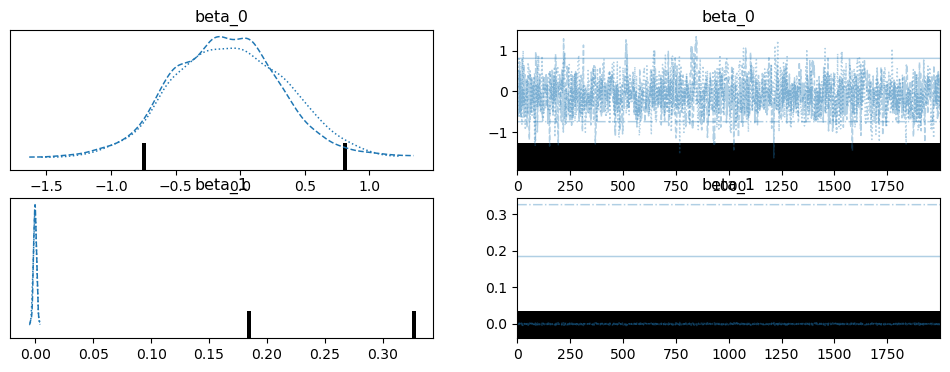

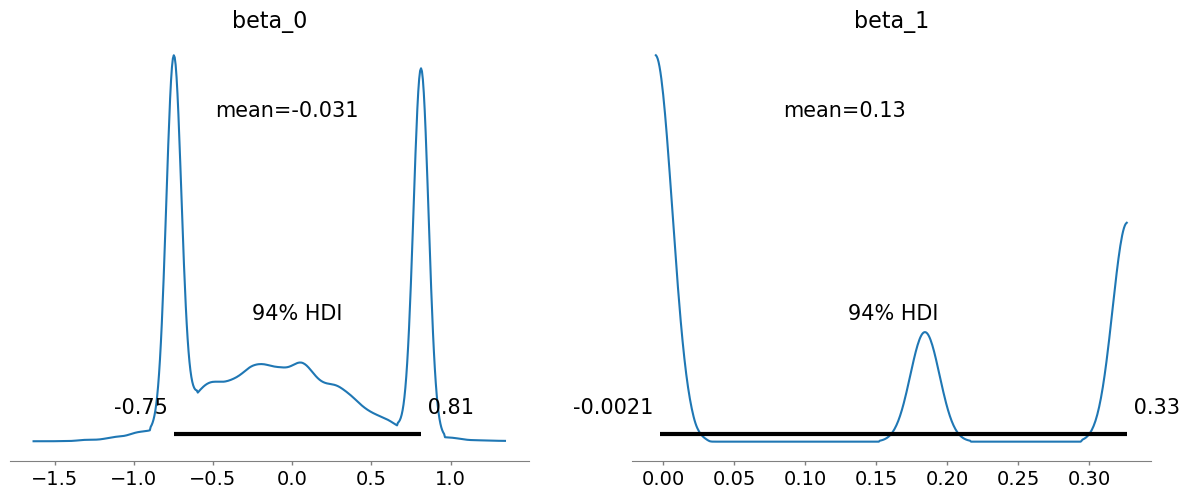

In [3]:
az.summary(trace, var_names=['beta_0', 'beta_1'])
az.plot_trace(trace, var_names=['beta_0', 'beta_1']);
az.plot_posterior(trace, var_names=['beta_0', 'beta_1']);

**Interpretation**

The posterior density plots show the estimated probability distribution for the model parameters.

The beta_0, or Intercept has a mean of 0.34 with 94% HDI lies in the interval (-0.41, 0.96). This interval also includes 0, so the intercept is not statistically significant.

The beta_1 or Coefficient for High_Risk_Cases has a mean of 0.44 with 94% HDI lies between -0.0013 and 0.75. This interval slightly includes 0, which means it's on the borderline of being significant.

Thus, the positive beta_1 suggests that more High_Risk_Cases has a higher probability of AI adoption.
However, the 94% HDI includes 0 slightly, meaning there's some uncertainty about whether this effect is real.


The trace plots, on the other hand, shows a good mixing and no strong trends. This suggests that the MCMC sampler converged well and there are no major sampling issues. Hence, the posterior estimates are reliable and no divergence issues were detected.

---
### Question 2

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [ ]:
# Select predictors (X)
X = df[["Employee_Workload"]].values
n, p = X.shape  # Get dimensions (rows, features)

# Select outcomes (Y)
Y = df[["Audit_Effectiveness_Score"]].values
m = Y.shape[1]  # Number of outcomes

In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Define Bayesian Multivariate Regression Model
with pm.Model() as model:
    
    # Define priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))  # Shape (p, m)
    
    # LKJ prior for covariance structure
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    
    # Define deterministic covariance matrix
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    # Multivariate Normal Likelihood
    y_obs = pm.MvNormal('y_obs', mu=X @ betas, chol=L, observed=Y)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)


---
### Question 3

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [4]:
df["AI_Used_for_Auditing"] = df["AI_Used_for_Auditing"].map({"Yes": 1, "No": 0})  # Convert Yes/No to 1/0
df["Fraud_Detected_Binary"] = (df["Fraud_Cases_Detected"] > 50).astype(int)  # Convert fraud count to binary

Y = df[["AI_Used_for_Auditing", "Fraud_Detected_Binary"]].values
X = df[["High_Risk_Cases", "Total_Audit_Engagements", "Compliance_Violations"]].values

df_sampled = df.sample(100, random_state=42)  # Take 100 random rows



In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Define model
with pm.Model() as model:
    
    # Define priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(X.shape[1], Y.shape[1]))  # Shape (p, m)
    
    # LKJ prior for correlation structure
    packed_L = pm.LKJCholeskyCov("packed_L", n=Y.shape[1], eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=Y.shape[1]), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(Y.shape[1], packed_L)
    
    # Latent variable
    z = pm.MvNormal('z', mu=X @ betas, chol=L, shape=(Y.shape[0], Y.shape[1]))  # Shape (n, m)
    
    # Observed binary outcome using Probit link function
    y_obs = pm.Bernoulli('y_obs', p=pm.math.invprobit(z), observed=Y)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

/opt/conda/lib/python3.11/site-packages/pymc/model/core.py:1302: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/opt/conda/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [betas, packed_L, z]
>BinaryGibbsMetropolis: [y_obs_unobserved]


In [ ]:
# Summarize the posterior distributions
az.summary(trace, var_names=['betas'])

# Plot posterior distributions
az.plot_posterior(trace, var_names=['betas'])